# Book Data Linkage Statistics

This notebook presents linkage statistics for the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from bookdata.db import db_url

## Load Link Stats

The `integration_stats` table in the database contains link success statistics in our data.

In [3]:
link_stats = pd.read_sql_table('integration_stats', db_url())
link_stats.head()

,dataset,gender,n_books,n_actions
0,LOC-MDS,no-loc-author,762676,NaN
1,LOC-MDS,female,587449,NaN
2,LOC-MDS,unknown,1210275,NaN
3,LOC-MDS,ambiguous,45109,NaN
4,LOC-MDS,male,1998004,NaN


Let's create lists for our different codes, in order, for later handling.  We'll start with the resolved codes:

In [4]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [5]:
unlink_codes = ['no-viaf-author', 'no-loc-author', 'no-book']

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot(index='dataset', columns='gender', values='n_books')
book_counts = book_counts.reindex(columns=link_codes + unlink_codes)
book_counts

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,200358.0,454137.0,14935.0,238571.0,151644.0,161628.0,1048330.0
BX-E,37725.0,55461.0,3567.0,17608.0,7733.0,6597.0,23269.0
BX-I,65934.0,96028.0,5944.0,36432.0,15844.0,13133.0,46664.0
GR-E,143969.0,237262.0,9093.0,86067.0,29328.0,575993.0,NaN
GR-I,145293.0,240157.0,9183.0,87719.0,30087.0,585145.0,NaN
LOC-MDS,587449.0,1998004.0,45109.0,1210275.0,294565.0,762676.0,NaN


In [7]:
act_counts = link_stats.pivot(index='dataset', columns='gender', values='n_actions')
act_counts = act_counts.reindex(columns=link_codes + unlink_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,3933128.0,6173925.0,449466.0,1977502.0,715198.0,2789674.0,6425383.0
BX-E,139925.0,185344.0,27700.0,27108.0,9926.0,9732.0,27194.0
BX-I,394833.0,468797.0,68092.0,77317.0,26774.0,26700.0,66452.0
GR-E,28464715.0,31304703.0,7307013.0,2670199.0,399775.0,16394093.0,NaN
GR-I,56774254.0,60951418.0,11554496.0,6665467.0,939429.0,52078951.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1: continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,0.088279,0.200095,0.006580,0.105116,0.066815,0.071214,0.461900
BX-E,0.248256,0.364971,0.023473,0.115873,0.050888,0.043413,0.153126
BX-I,0.235496,0.342983,0.021230,0.130124,0.056590,0.046907,0.166670
GR-E,0.133094,0.219339,0.008406,0.079566,0.027113,0.532483,NaN
GR-I,0.132375,0.218805,0.008367,0.079920,0.027412,0.533121,NaN
LOC-MDS,0.119935,0.407916,0.009210,0.247092,0.060139,0.155709,NaN


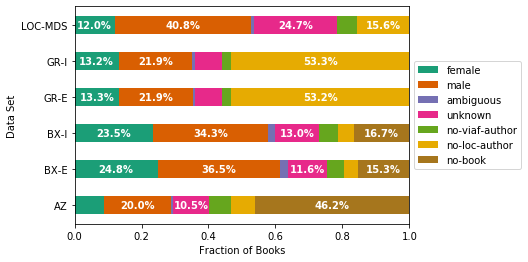

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.088279,0.200095,0.006580,0.105116,0.599930
BX-E,0.248256,0.364971,0.023473,0.115873,0.247427
BX-I,0.235496,0.342983,0.021230,0.130124,0.270167
GR-E,0.133094,0.219339,0.008406,0.079566,0.559595
GR-I,0.132375,0.218805,0.008367,0.079920,0.560533
LOC-MDS,0.119935,0.407916,0.009210,0.247092,0.215848


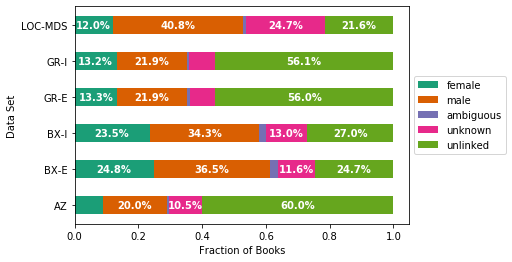

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

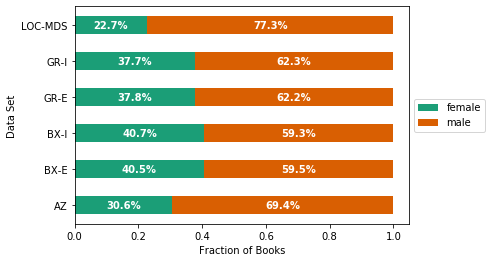

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,0.175084,0.274833,0.020008,0.088029,0.031837,0.124183,0.286027
BX-E,0.327748,0.434133,0.064882,0.063495,0.023250,0.022795,0.063697
BX-I,0.349730,0.415245,0.060314,0.068485,0.023716,0.023650,0.058861
GR-E,0.328918,0.361735,0.084435,0.030855,0.004620,0.189438,NaN
GR-I,0.300450,0.322556,0.061147,0.035274,0.004971,0.275602,NaN


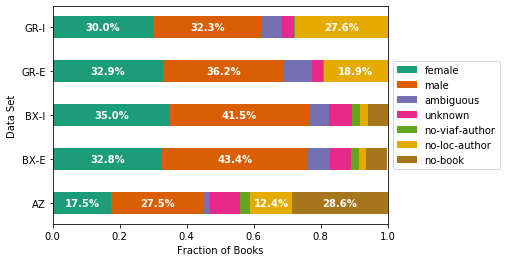

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.175084,0.274833,0.020008,0.088029,0.442047
BX-E,0.327748,0.434133,0.064882,0.063495,0.109742
BX-I,0.349730,0.415245,0.060314,0.068485,0.106226
GR-E,0.328918,0.361735,0.084435,0.030855,0.194058
GR-I,0.300450,0.322556,0.061147,0.035274,0.280574


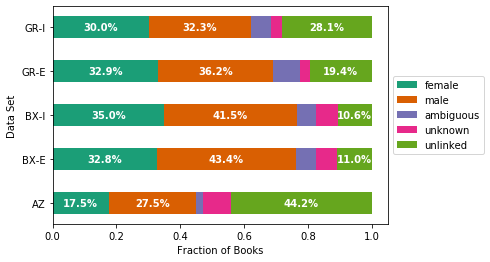

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

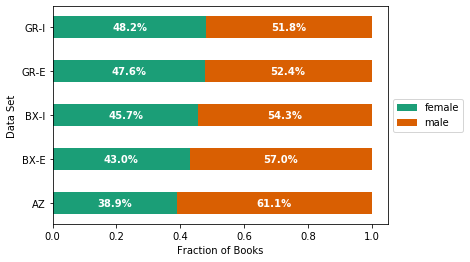

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))